In [1]:
import numpy as np
from numpy import inner,sqrt,sin,cos,arctan2,pi,add,array,zeros,sum,arccos,log,arctan,linspace
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

Monte Carlo Transport from a cloud with Thomson scattering
==

In this lab we will determine the polarization signal from photons emerging from asymmetric cloud with an atmosphere dominated by Thomson scattering.  The setup will vary with the exact problem, by each problem will be
1. inject a large number of photons in the core of the cloud with random polarizations and directions
2. transport the photons until a scattering occurs or the photon leaves the cloud
    - if scatters, then change direction assuming Thomson scattering
3. Once the photon has left the cloud, determine its final trajectory and record properties

Variation of the problem could include different shapes of the cloud, different density profiles, different opacities, different emission locations, etc.

We will work through a basic example, you will fill in key steps in the lab with the help of your partner and the teacher and lab assistant.

But first, a few setup things

Defining our Environment
==

The photons will be produced in the center of a gas cloud.  Here we create a cloud class and define some basics of it

In [4]:
class Cloud:
  def __init__(self, maxtau=1.0, axesratio=1.0):    

    #oblate if axesratio < 1
    if axesratio < 1: self.axes = array([1.0,1.0,axesratio])        
    #prolate if axesratio > 1
    if axesratio >=1: self.axes = array([1.0/axesratio,1.0/axesratio,1.0])

    #non 0 n's is not setup, but you could do it
    #you would need to define dens(r) such that: 
    #\int dens*kappa*dr along the max axes is maxtau
    #you also need to consider that the mean free path changes with 
    #density so that it is not enough to assume it is constant over
    #the path of the photon
    self.n = 0 
    
    #we are given the maximum tau of the cloud. 
    #For constant density, maxtau = kappa*density*largest axes
    #we are in units where the largest axes is always 1
    #we can take kappa=1 too
    self.kappa = 1.0
    self.dens = maxtau
    
    
def check_in_cloud(pos,cloud):
    check = sum((pos/cloud.axes)**2)
    if check>1: return False
    else: return True

Is the point 0,0,1 in the cloud?: False
Is the point 0,0,0.25 in the cloud?: True
Is the point 1,1,0 in the cloud?: False
Is the point 1,0,0 in the cloud?: True


C:\Users\keyur\AppData\Local\Temp/ipykernel_13552/500170429.py:21: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


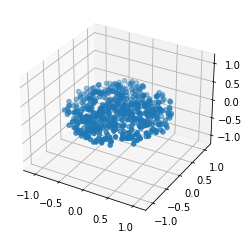

Check that the axes ranges make sense for an axes ratio of: 0.5
Should be oblate for axesratio < 1 and prolate for axesratio > 1


In [6]:
#oblate cloud
#%matplotlib widget

axesratio = 0.5
test_cloud = Cloud(1.0,axesratio)
#lets check
print("Is the point 0,0,1 in the cloud?:",check_in_cloud(array([0.0,0.0,1.0]),test_cloud))
print("Is the point 0,0,0.25 in the cloud?:",check_in_cloud(array([0.0,0.0,0.25]),test_cloud))
print("Is the point 1,1,0 in the cloud?:",check_in_cloud(array([1.0,1.0,0.0]),test_cloud))
print("Is the point 1,0,0 in the cloud?:",check_in_cloud(array([1.0,0.0,0.0]),test_cloud))

a=[]
for i in range(2000):
    x = 2.0*rng.random()-1.0
    y = 2.0*rng.random()-1.0
    z = 2.0*rng.random()-1.0
    if check_in_cloud(array([x,y,z]),test_cloud)==True: 
        a.append([x,y,z])

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y, Z = array(a).T[0],array(a).T[1],array(a).T[2]
ax.scatter(X, Y, Z)
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.2,1.2)
ax.set_zlim(-1.2,1.2)
plt.show()
print("Check that the axes ranges make sense for an axes ratio of:",axesratio)
print("Should be oblate for axesratio < 1 and prolate for axesratio > 1")

Defining the Photons
==

This comes from the concepts notebook.  We also have the function for a random direction on the sky here

In [8]:
def random_direction():
    phi = rng.random()*2.0*pi #uniform random between 0 and 2pi
    costheta = 2.0*rng.random()-1.0 #unifrom random between -1 and 1
    sintheta = sqrt(1.0-costheta**2) #need sin(theta) for the cartesian cordinates
    return array([sintheta*cos(phi),sintheta*sin(phi),costheta])

class Photon:
    def __init__(self,init_pos=None,init_vel=None):
        #if not specified, set initial position to origin
        self.pos = init_pos if init_pos is not None else array([0.0,0.0,0.0])

        #if not specified, assume isotropic
        #photons will travel with speed c=1
        self.vel = init_vel if init_vel is not None else random_direction() 

        #polarization is perpendicular to vel.
        #Find two vectors perp to vel, then take random 
        pvec = random_direction() 

        #pvec cross vel will be perp to vel.
        pvec1=zeros(3)
        pvec1[0] = pvec[1]*self.vel[2]-pvec[2]*self.vel[1]
        pvec1[1] = -(pvec[0]*self.vel[2]-pvec[2]*self.vel[0])
        pvec1[2] = pvec[0]*self.vel[1]-pvec[1]*self.vel[0]
        pvec1 /= sqrt(inner(pvec1,pvec1)) #normalize

        #pvec1 cross vel will be perp to vel and pvec1
        pvec2=zeros(3)
        pvec2[0] = pvec1[1]*self.vel[2]-pvec1[2]*self.vel[1]
        pvec2[1] = -(pvec1[0]*self.vel[2]-pvec1[2]*self.vel[0])
        pvec2[2] = pvec1[0]*self.vel[1]-pvec1[1]*self.vel[0]
        pvec2 /= sqrt(inner(pvec2,pvec2)) #normalize

        angle = rng.random()*2.0*pi
        self.pol = add(pvec1*cos(angle),pvec2*sin(angle))
        self.pol /= sqrt(inner(self.pol,self.pol))

    #return the current speed  = norm(vel)
    def speed(self):
        return sqrt(inner(self.vel,self.vel)) #put the expression here

    #propagate the photon a time dt, update the position.
    def move(self,dt):
        self.pos += self.vel*dt #put the expression here

    #scatter the photon into new direction, need to be careful with the new polarization
    #after a scatter into new direction, the new polarization will be perp
    #to the new direction, and parallel to the old polarization
    def scatter(self,new_direction):
        newpol = self.pol - inner(new_direction,self.pol)*new_direction
        newpol /= sqrt(inner(newpol,newpol))
        
        self.vel = new_direction
        self.pol = newpol

Defining the photon interactions
==
We assume the photons interact via Thomson scattering.  The problem setup (by setting a maximum optical depth) sets the length scale/density of the system and therefore we don't have to worry about the exact Thomson cross section. In the reduced units of this setup the opacity is cloud.kappa, the density is cloud.dens, and the mean free path is 1/(kappa*dens).  

In [10]:
def get_mfp(pos,cloud):
    #in principle the mean free path may depend on
    #position in the cloud, but since n=0, not here
    imfp = (cloud.kappa*cloud.dens) #put the expression here
    return 1.0/imfp

#oblate cloud
axesratio = 0.5
test_cloud = Cloud(1.0,axesratio)
test_photon = Photon()
print("The mean free path in this cloud is: lambda =",get_mfp(test_photon,test_cloud))
test_cloud = Cloud(2.0,axesratio)
test_photon = Photon()
print("Note, if we increase the maximum optical depth to 2.0, the mean free path gets smaller: lambda =",get_mfp(test_photon,test_cloud))


The mean free path in this cloud is: lambda = 1.0
Note, if we increase the maximum optical depth to 2.0, the mean free path gets smaller: lambda = 0.5


The photon travelling through such a medium can travel until it interacts. The probability of travel a distance d is proportional to exp(-d/mfp).  Given this probability, we can sample a distance travelled.  Below we show a distribution of potential distances between interactions.  For a mean free path of 1, it is very unlikely to travel a distance of ~10, roughly 1 in 10^5, or ~exp(-10).

Given this setup, we can sample a distance traveled by a photon: 2.2046675925813988


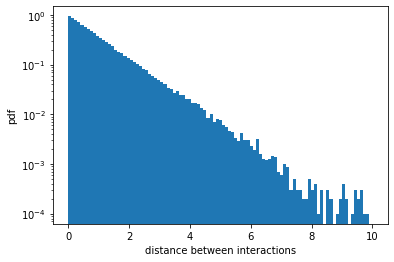

In [19]:
def get_MC_distance(photon,cloud):
    mfp = get_mfp(photon,cloud)
    return -mfp*log(rng.random())

#oblate cloud
axesratio = 0.5
test_cloud = Cloud(1.0,axesratio)
test_photon = Photon()
print("Given this setup, we can sample a distance traveled by a photon:",get_MC_distance(test_photon,test_cloud))
distance = zeros(100000)
for i in range(len(distance)):
    distance[i] = get_MC_distance(test_photon,test_cloud)

fig, ax = plt.subplots()
plt.hist(distance,density=True,bins=linspace(0,10,100))
plt.yscale('log')
plt.xlabel('distance between interactions')
plt.ylabel('pdf')
plt.show()

Thomson Scattering
==

When the photon Thomson scatters it doesn't scatter isotropically.  Recall, the incoming photon has an electric field.  This field accelerates the electron and the electron radiates in a very specific pattern.  Our Monto Carlo photons must respect this angular distribution of scattering photons.  

Recall, $\frac{dP}{d\Omega} \propto \sin^2(\theta)$ where $\sin(\theta)$ is the sine of the angle between the direction of the incoming photon's polarization (i.e. the electric field) and the outgoing scattered direction.  In practice this means that photons cannot be scattered in the direction of the polarization of the incoming photon.

In practice, we'll do this by setting up a MC generator like we did for $sin^2$ before, but now $dP \propto \sin^2(\theta) d(cos(\theta)) d\phi = \sin^3(\theta) d\theta d\phi$.  So we pick a random number ($\theta$) from 0 to $\pi$ and a random number ($y$) between 0 and 1. We accept the $\theta$ if $y$ is less than $\sin(\theta)^3$. We repeat until we get a $\theta$ that satesfies our criteria. We also pick a random number $\phi$ between 0 and $2\pi$.

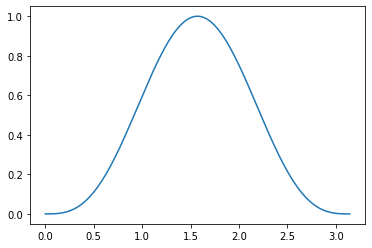

A sample scattering direction: (2.1806462004230958, 3.524644015726474)
Here, thetas near pi/2 are much more likely then near 0 or pi


In [21]:
plt.clf()
x = linspace(0,pi,1000)
plt.plot(x,sin(x)**3)
plt.show()

def thomson_scatter_direction():
    need_direction = True
    while(need_direction):
        x = pi*rng.random()
        y = rng.random()
        if y < sin(x)**3:
            need_direction = False
    theta = x
    phi = rng.random()*2.0*pi
    return theta,phi
    
print("A sample scattering direction:",thomson_scatter_direction())
print("Here, thetas near pi/2 are much more likely then near 0 or pi")



Now the last part in the photon interaction is determining the new direction (in the cloud's frame) and the new polarization. First, get a set of three perpendicular vectors, #1: the old polarization direction, #2: the old propagation direction, and #3: the cross product of #1 and #2. The new direction will use the random number $\phi$ above with the vectors #2 and #3 to determine the new azimuthal direction.  The then we use the $\theta$ to get the componant of the new direction parallel to the old polarization #1.

For the new polarization.  We'll subtract out from the old polarization any componant in the new direction, then normalize it back to unit.

In [24]:
def thomson_scatter(photon,theta,phi):
    vec1 = photon.pol #put the expression here
    vec2 = photon.vel #put the expression here
    vec3 = array([vec1[1]*vec2[2]-vec1[2]*vec2[1],-(vec1[0]*vec2[2]-vec1[2]*vec2[0]),vec1[0]*vec2[1]-vec1[1]*vec2[0]])
    vec3 /= inner(vec3,vec3)
    
    
    newdirection_plane = (vec2*cos(phi) + vec3*sin(phi))*sin(theta)
    newdirection_pole = vec1*cos(theta)
    newdirection = newdirection_pole + newdirection_plane

    newpol = photon.pol - inner(photon.pol,newdirection)*newdirection
    newpol /= sqrt(inner(newpol,newpol))

    photon.vel = newdirection
    photon.pol = newpol
    

In [25]:
test_photon = Photon()
theta,phi = thomson_scatter_direction()
thomson_scatter(test_photon,theta,phi)
print("Thomspon Scattered")
print("The velocity of the photon is:",test_photon.vel,"with a speed:",test_photon.speed())
print("The polarization (and its normalization) of the photon is:",test_photon.pol,inner(test_photon.pol,test_photon.pol))
print("As a check, the velocity and polarization are perpendicular:",inner(test_photon.vel,test_photon.pol))

Thomspon Scattered
The velocity of the photon is: [ 0.83656585  0.22332438 -0.50028372] with a speed: 0.9999999999999999
The polarization (and its normalization) of the photon is: [-0.44732612 -0.24879157 -0.85907048] 1.0
As a check, the velocity and polarization are perpendicular: 3.7517543874382356e-16


Monte Carlo Transport of Photon through Cloud
==

We are now ready to follow the transport through the cloud.  We'll make a visuallization of it to clearly see what is happening.  Rerun this cell to get different realizations of the transport.

In [ ]:
#%matplotlib widget
#make a cloud and a photon
mycloud = Cloud(maxtau=2.0,axesratio=0.5)
myphoton = Photon()

#for imaging purposes, keep track of each position, we don't normally have to do this,
#we only care about the final trajectory of the photon once it has left the cloud
positions = []
positions.append(myphoton.pos*1.0) #here we need the *1.0 since otherwise we will just
                                   #store copies of the current position, which changes
                                   #as the photon moves.  This is a non-intuitive quirk
                                   #of python.

#first sample a distance based on the mean free path of the cloud
distance = get_MC_distance(myphoton,mycloud) #put the expression here

#next, find the dt associated with that distance and move that far
dt = ? #put the expression here
myphoton.move(dt)
positions.append(myphoton.pos*1.0)

#next, if we are still in the cloud, we need to thomson scatter and move again
#we repeat until we are out of the cloud
count = 0
while(check_in_cloud(myphoton.pos,mycloud)):
    #scatter!
    count += 1
    #here you need to scatter, determine the next step size and move again
    ?
    ?
    ?
    
    positions.append(myphoton.pos*1.0)
    
#just for illustraitive purposes, this is how many times we scattered.
#Try playing with the maxtau variable to see how it changes
print("Times Scattered:",count)

#next, plot the positions and the paths of the photon
positions = np.asarray(positions)
fig = plt.figure()
ax = Axes3D(fig)
fig.add_axes(ax)
#ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions.T[0][1:-1],positions.T[1][1:-1],positions.T[2][1:-1])
ax.plot(positions.T[0],positions.T[1],positions.T[2],'--')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

#mark the origin with a black dot
ax.scatter(positions.T[0][0],positions.T[1][0],positions.T[2][0],c='k',s=20)
#mark the final escaped position with a red dot
ax.scatter(positions.T[0][-1],positions.T[1][-1],positions.T[2][-1],c='r',s=20)

#from stack overflow... plot a wire frame of our cloud.
n_meridians=40
centre = array([0,0,0])
radius=1
n_circles_latitude = max(n_meridians/2, 4)
u, v = np.mgrid[0:2*pi:n_meridians*1j, 0:pi:n_circles_latitude*1j]
sphere_x = centre[0] + mycloud.axes[0] * cos(u) * sin(v)
sphere_y = centre[1] + mycloud.axes[1] * sin(u) * sin(v)
sphere_z = centre[2] + mycloud.axes[2] * cos(v)
ax.plot_wireframe( sphere_x, sphere_y, sphere_z, color="r", alpha=0.1)

plt.show()

Extracting data from each photon
==

The last thing we need to do is transform the escaped photon into useable data.  These clouds are axisymmetric, so for an observer there is only one degree of freedom, the angle with respect to the polar axis.  We'll call this the inclination angle $i$.  In the reference paper Hoeflich (1991), this is often writen down as $\sin^2(i)$. So we need to figure out the $\sin^2(i)$ of the escaping photon. We will also record some data as a function of the location on the projected sky.  In total, this is the data we save, each photon contributs to each one

1. Stokes I on the projected sky for each observer inclination (**spatial_I**)
2. total Stokes I for each observer inclination (**total_intensity**)
3. I_(y) intensity after passing through a vertical polarization filter (**netpol_Iy**)
4. I_(x) intensity after passing through a horizontal polarization filter (**netpol_Ix**)
5. Stokes U intensity for each observer. (**netpol_U**)
6. spatial_angle: not really a stokes parameter, but this is related to the
   angle of the electric field on the projected sky: |arctan(Ex/Ey)|. It goes from 0 degrees 
   (vertical electric field), to 90 degrees, horizontal field. It is determined as a
   function of observer inclination and projected sky location (**spatial_angle**)
   
The function below returns a dictionary of these arrays we will use to populate with each photon

In [ ]:
def init_observer_data(nsin2i=20,nx=40,ny=40):

    obs_data = {}
    #lets store the following data
    #split the observer inclination angles into nsin2i bins
    obs_data["nsin2i"] = nsin2i
    obs_data["sin2is"] = linspace(0,1,nsin2i,endpoint=False)+0.5/nsin2i

    #split the resolved projected sky into nx,ny bins from -1 to 1
    obs_data["nx"] = nx
    obs_data["ny"] = ny
    obs_data["x"] = linspace(-1,1,nx,endpoint=False)+0.5*(1-(-1))/nx
    obs_data["y"] = linspace(-1,1,nx,endpoint=False)+0.5*(1-(-1))/ny
    
    obs_data["spatial_angle"] = zeros(nx*ny*nsin2i).reshape(nsin2i,nx,ny)
    obs_data["spatial_I"]= zeros(nx*ny*nsin2i).reshape(nsin2i,nx,ny)-0.00001 #for normalization, ignore the 0.0001, prevents a /0

    obs_data["netpol_Iy"] = zeros(nsin2i) #will contain the net polarization in the vertical direction
    obs_data["netpol_Ix"] = zeros(nsin2i) #will contain the net polarization in the horizontal direction
    obs_data["netpol_U"] = zeros(nsin2i) #will contain Stokes U
    obs_data["total_intensity"] = zeros(nsin2i) #will contain Stokes I
    
    return obs_data
    
my_obs_data = init_observer_data(20,40,40)

First, after a very long propagation distance to Earth the position unit vector is essentially the velocity unit vector.  Since we aligned the axisymmetry axis along the $z$, we have that $\cos(i) = v_z$, or $\sin^2(i)=1-v_z^2$.  $\sin^2(i)$ goes from 0 to 1, so we can pick $n_{\sin^2(i)}$ bins and put each photon into the appropiate one: $n = \mathrm{int}[n_{\sin^2(i)}*(1-v_z^2)]$, which will give integers between 0 and n_{\sin^2(i)}-1 (note $\mathrm{int}[\ldots]$ here mean the floor function, or casting, rounding down to the nearest integer).
 
Now we have the inclination, but we still need to extract the polarization. Our observer can measure two polarizations.  For ease, we'll choose to align one of these in the direction of the projected polar axis (although an observer may not have this luxury, they can still extract the same info) and the other perpendicular to this.  Note, the projected polar axis is not $z$ here, that is only the case for an observer at an inclination of 90 degrees.  

In [ ]:
def observe_photon(photon,obs_data):

    #first, we need to determine the theta and phi of the observer at infinity.
    #For very large distances (travel times) from the cloud the position vector
    #will just be the velocity vector * time since anywhere in the cloud is
    #effectively the origin.  So the unit vector setting the direction is just \hat{v}
    costheta_inf = photon.vel[2]
    sintheta_inf = sqrt(1-photon.vel[2]**2)
    sintheta_inf2 = 1-photon.vel[2]**2
    cosphi_inf = cos(arctan2(photon.vel[1],photon.vel[0]))
    sinphi_inf = sin(arctan2(photon.vel[1],photon.vel[0]))



    #if we want to spatially resolve the polarization signal, need the projected
    #location on the sky. 
    #First, get the projection of the photon's position perpendicular to the velocity
    rperp = photon.pos - photon.vel*inner(photon.pos,photon.vel)/inner(photon.vel,photon.vel)

    #then get the vertical and horizontal componants for mapping
    rvert = costheta_inf*cosphi_inf*rperp[0] + costheta_inf*sinphi_inf*rperp[1] - sintheta_inf*rperp[2]
    rhorz = -sinphi_inf*rperp[0] + cosphi_inf*rperp[1]

    #do the same for the polarization vector.  Note, the polarization vector is already aligned
    #with the plane perpendicular to the velocity, by definition
    pvert = costheta_inf*cosphi_inf*photon.pol[0] + costheta_inf*sinphi_inf*photon.pol[1] - sintheta_inf*photon.pol[2]
    phorz = -sinphi_inf*photon.pol[0] + cosphi_inf*photon.pol[1]

    nx = obs_data["nx"]
    ny = obs_data["ny"]
    nsin2i = obs_data["nsin2i"]

    sin2ibin = int(abs(sintheta_inf2)*nsin2i)
    nxbin = int(nx*0.5*(rhorz+1.0))
    nybin = int(ny*0.5*(rvert+1.0))

    obs_data["spatial_angle"][sin2ibin,nxbin,nybin] += np.abs(arctan(phorz/pvert))
    obs_data["spatial_I"][sin2ibin,nxbin,nybin] += ? #put the expression here

    obs_data["netpol_Iy"][sin2ibin] += ? #put the expression here
    obs_data["netpol_Ix"][sin2ibin] += ? #put the expression here
    
    obs_data["netpol_U"][sin2ibin] += ? #put the expression here

    obs_data["total_intensity"][sin2ibin] += ? #put the expression here

observe_photon(myphoton,my_obs_data)
print("For example, now we have some intensity somewhere in our data")
print(my_obs_data["total_intensity"])
print("This is not normalized yet, but for that we need a lot of photons")

First Monte Carlo Simulation
==

Now we'll put everything together and simulate many photons and look at the polarizations signals

In [ ]:
obs_data = init_observer_data(20,40,40)
axesratio = 0.5
cloud = Cloud(maxtau=1.0,axesratio=axesratio)

n_photons = 100000

for i in range(n_photons):
    #make a photon
    photon = Photon()

    #first sample a distance based on the mean free path of the cloud
    distance = get_MC_distance(photon,cloud)

    #next, find the dt associated with that distance and move that far
    dt = distance/photon.speed()
    photon.move(dt)

    #next, if we are still in the cloud, we need to thomson scatter and move again
    #we repeat until we are out of the cloud
    while(check_in_cloud(photon.pos,cloud)):
        #scatter!
        ?
        ?
        ?
        
    observe_photon(photon,obs_data)

#normalize
obs_data["spatial_angle"] /= obs_data["spatial_I"]
obs_data["Q"] = obs_data["netpol_Iy"] - obs_data["netpol_Ix"]
obs_data["I"] = obs_data["netpol_Iy"] + obs_data["netpol_Ix"]
obs_data["U"] = obs_data["netpol_U"]


In [ ]:
#plt.plot(obs_data["sin2is"],obs_data["I"]/obs_data["I"],label="I/I")
plt.plot(obs_data["sin2is"],obs_data["Q"]/obs_data["I"],label="Q/I")
plt.plot(obs_data["sin2is"],obs_data["U"]/obs_data["I"],label="U/I")
plt.legend(frameon=False,fontsize=16)
plt.xlabel(r"$\sin^2(i)$")
plt.show()

In [ ]:
#Now plot the net polarization
plt.plot(obs_data["sin2is"],,label=r"$\Pi = I_{pol}/I$")
plt.legend(frameon=False,fontsize=16)
plt.xlabel(r"$\sin^2(i)$")
plt.show()

In [ ]:
sin2ibin = 9
plt.imshow(obs_data["spatial_angle"][sin2ibin,:,:].T,interpolation='none',origin='lower',vmin=-0.,vmax=pi/2.,cmap='seismic',extent=[obs_data["x"][0],obs_data["x"][-1],obs_data["y"][0],obs_data["y"][-1]])
plt.gca().annotate('$sin^2(i)$='+str("%.4f" % round(obs_data["sin2is"][sin2ibin],4)), xy=(-0.9, 0.8), xycoords='data',c='w',fontsize=16)
pinet = sqrt(obs_data["U"][sin2ibin]**2+obs_data["Q"][sin2ibin]**2)/obs_data["I"][sin2ibin]
plt.gca().annotate('$\Pi$='+str("%.4f" % round(pinet,4)), xy=(-0.9, -0.8), xycoords='data',c='w',fontsize=16)


plt.colorbar()

In [ ]:
sin2ibin = 9
plt.imshow(np.log10(obs_data["spatial_I"][sin2ibin,:,:].T+0.00001+1),interpolation='none',origin='lower',extent=[obs_data["x"][0],obs_data["x"][-1],obs_data["y"][0],obs_data["y"][-1]])
plt.gca().annotate('$sin^2(i)$='+str("%.4f" % round(obs_data["sin2is"][sin2ibin],4)), xy=(-0.9, 0.8), xycoords='data',c='w',fontsize=16)
pinet = sqrt(obs_data["U"][sin2ibin]**2+obs_data["Q"][sin2ibin]**2)/obs_data["I"][sin2ibin]
plt.gca().annotate('$\Pi$='+str("%.4f" % round(pinet,4)), xy=(-0.9, -0.8), xycoords='data',c='w',fontsize=16)


plt.colorbar()